In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.common.utils.image import load_image
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV
from torchlake.object_detection.models.yolov1 import YOLOV1Modified, YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
# import time
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov1')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov1",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 448

In [9]:
transform = A.Compose(
    [
        # A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=transform,
)

In [11]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [13]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 448, 448]) 32


# model

In [14]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["4_1"])

In [15]:
model = YOLOV1Modified(backbone, CONTEXT).to(CONTEXT.device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV1Modified                                     --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        221,952
│    │    └─Sequential: 3-3                        1,116,416
│    │    └─Sequential: 3-4                        6,822,400
│    │    └─Sequential: 3-5                        13,114,368
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─Sequential: 1-2                                  --
│    └─Conv2dNormActivation: 2-3                   --
│    │    └─Conv2d: 3-7                            4,718,592
│    │    └─BatchNorm2d: 3-8                       2,048
│    │    └─LeakyReLU: 3-9                         --
│    └─Conv2dNormActivation: 2-4                   --
│    │    └─Conv2d: 3-10             

# train

In [17]:
EPOCH = 10

In [18]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, lambda_coord=5, lambda_noobject=0.5)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [21]:
# TODO: longer epoch
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 517/517 [13:12<00:00,  1.53s/it]


epoch 1 : 0.0006664902905954275


100%|██████████| 517/517 [05:03<00:00,  1.70it/s]


epoch 2 : 0.0005154014020465581


100%|██████████| 517/517 [05:16<00:00,  1.64it/s]


epoch 3 : 0.00047649101469471214


100%|██████████| 517/517 [05:05<00:00,  1.69it/s]


epoch 4 : 0.0004518564586253833


100%|██████████| 517/517 [05:02<00:00,  1.71it/s]


epoch 5 : 0.0004409828856704501


100%|██████████| 517/517 [05:06<00:00,  1.69it/s]


epoch 6 : 0.00042534915210091015


100%|██████████| 517/517 [05:04<00:00,  1.70it/s]


epoch 7 : 0.0004076559638232533


100%|██████████| 517/517 [05:08<00:00,  1.68it/s]


epoch 8 : 0.0004180347035450742


100%|██████████| 517/517 [05:00<00:00,  1.72it/s]


epoch 9 : 0.0004027732568862803


100%|██████████| 517/517 [05:06<00:00,  1.69it/s]

epoch 10 : 0.0003836961585870265


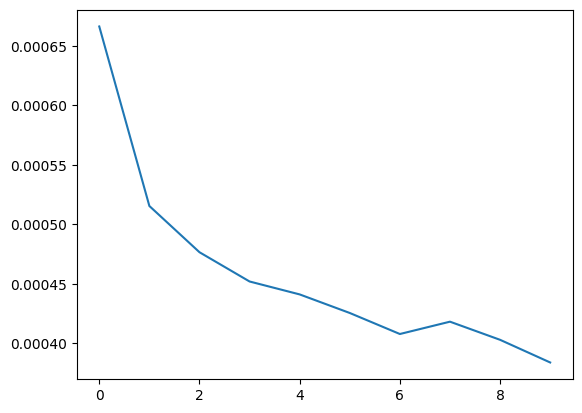

In [22]:
plt.plot(training_loss)

In [17]:
model_path = artifact_path / f'yolov1.{backbone.network_name}.pth'

In [24]:
torch.save(model.state_dict(), model_path)

In [25]:
get_file_size(model_path)

'216.44MiB'

In [18]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Inference

In [19]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [20]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [21]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [22]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [23]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [24]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [25]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [26]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [27]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:01<?, ?it/s]


In [28]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

sofa: 0.24
car: 0.50
pottedplant: 0.13
pottedplant: 0.13
pottedplant: 0.24
pottedplant: 0.16
dog: 0.13
person: 0.25
person: 0.60
person: 0.34
person: 0.38
person: 0.24
person: 0.19
person: 0.34
train: 0.27
car: 0.47
person: 0.23
person: 0.21
person: 0.25
person: 0.26
dog: 0.13
car: 0.30
car: 0.32
chair: 0.24
person: 0.13
person: 0.14
person: 0.25
pottedplant: 0.18
dog: 0.23
person: 0.16
person: 0.36
person: 0.38
person: 0.14
pottedplant: 0.18
sofa: 0.13
person: 0.33
horse: 0.19
sofa: 0.20
horse: 0.20
person: 0.43
bottle: 0.20
chair: 0.27
chair: 0.16
aeroplane: 0.13
aeroplane: 0.28
person: 0.50
car: 0.54
bird: 0.27
bicycle: 0.45
dog: 0.54
dog: 0.17
person: 0.21
person: 0.40
person: 0.19
person: 0.25
person: 0.37
person: 0.13
person: 0.17
person: 0.40
bird: 0.12
bird: 0.11
dog: 0.21


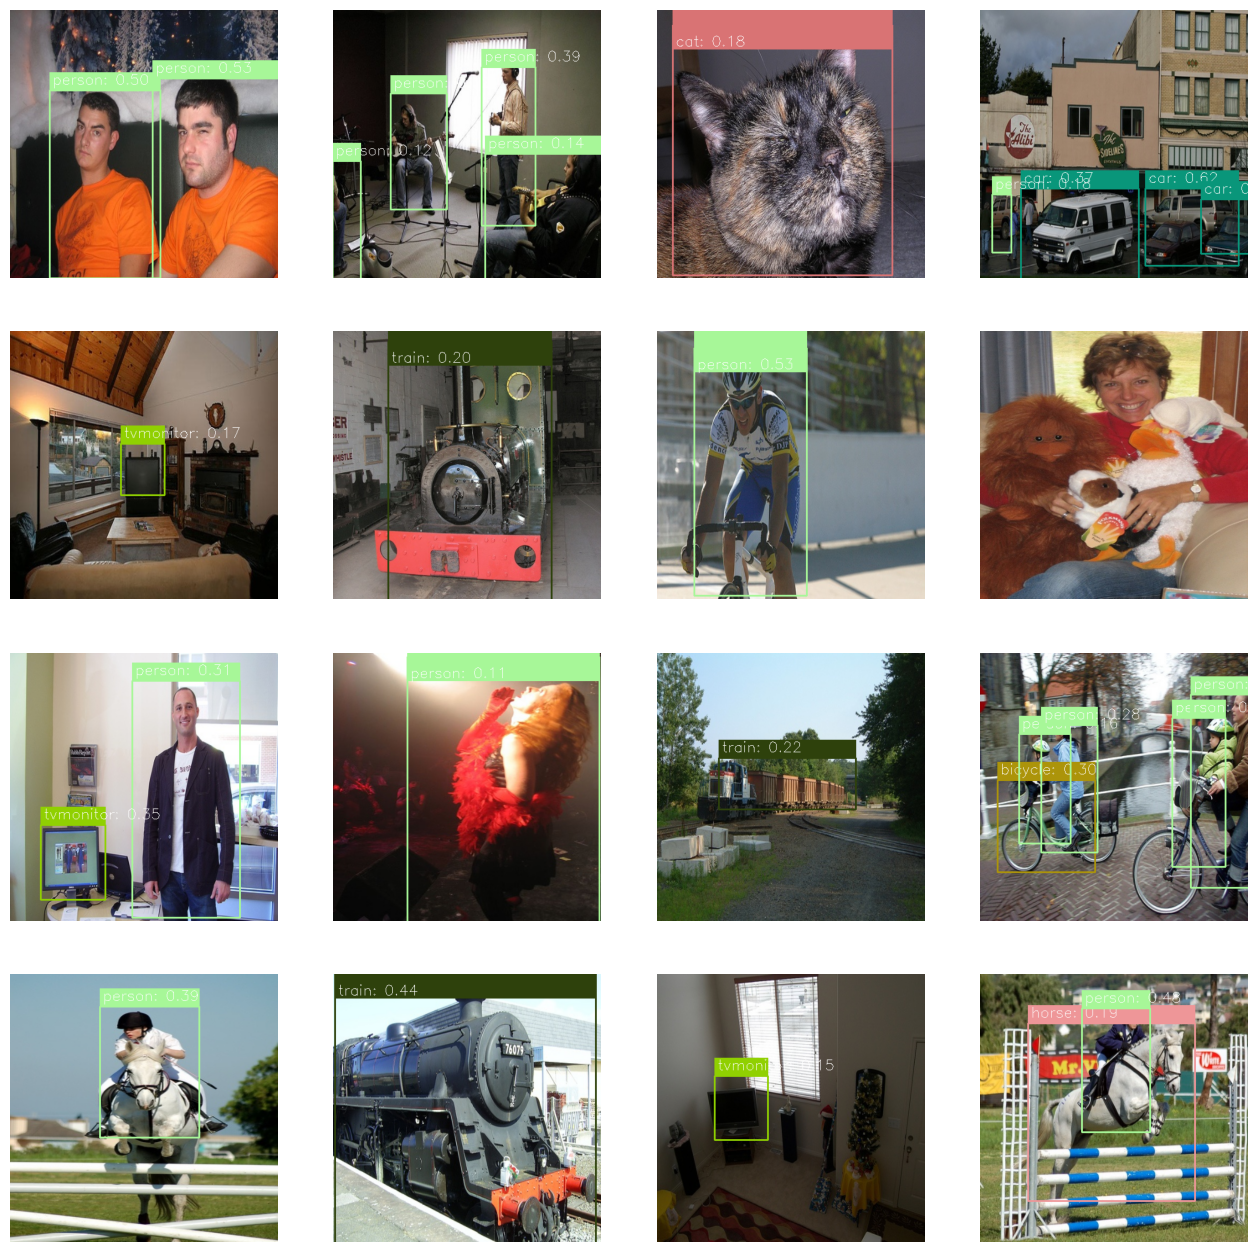

In [30]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [29]:
humans_img = "D://W/gf/1672998424399.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.40
person: 0.11
person: 0.35
D://W/gf/1672998424399.jpg 3
person: 0.36
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.36
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [25]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.25
person: 0.23
person: 0.24
person: 0.22
person: 0.25
person: 0.24
person: 0.22
person: 0.20
person: 0.23
person: 0.21
person: 0.26
person: 0.25
person: 0.22
person: 0.23
person: 0.27
person: 0.30
person: 0.29
person: 0.29
person: 0.10
person: 0.15
person: 0.15
person: 0.19
person: 0.18
person: 0.23
person: 0.24
person: 0.16
person: 0.11
person: 0.11
person: 0.12
person: 0.11
person: 0.13
person: 0.10
person: 0.12
person: 0.12
person: 0.11
person: 0.22
person: 0.21
person: 0.20
person: 0.18
person: 0.20
person: 0.24
person: 0.26
person: 0.27
person: 0.27
person: 0.26
person: 0.24
person: 0.27
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.21
person: 0.21
person: 0.20
person: 0.21
person: 0.20
person: 0.19
person: 0.19
person: 0.21
person: 0.22
person: 0.22
person: 0.25
person: 0.28
person: 0.27
person: 0.31
person: 0.30
person: 0.30
person: 0.28
person: 0.29
person: 0.30
person: 0.29
person: 0.27
person: 0.28
person: 0.28
person: 0.29

# evaluation

In [30]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [40]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [41]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [42]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [43]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [44]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [45]:
evaluator = Evaluator(CONTEXT)

In [46]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [01:19<00:00,  1.95it/s]

       aeroplane   bicycle      bird     boat    bottle       bus       car  \
AP@0.5  0.531946  0.528568  0.515521  0.50381  0.416331  0.418011  0.506116   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.513695  0.497757  0.427842  ...  0.504238  0.506321  0.506917   

         person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.50146    0.498161  0.497216  0.496733  0.498654  0.498748  0.489846  

[1 rows x 21 columns]


In [47]:
result_table.T

AP@0.5
aeroplane    0.531946
bicycle      0.528568
bird         0.515521
boat          0.50381
bottle       0.416331
bus          0.418011
car          0.506116
cat          0.513695
chair        0.497757
cow          0.427842
diningtable   0.42887
dog          0.504238
horse        0.506321
motorbike    0.506917
person        0.50146
pottedplant  0.498161
sheep        0.497216
sofa         0.496733
train        0.498654
tvmonitor    0.498748
all          0.489846

In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )

bird: 0.37
person: 0.34
person: 0.31
person: 0.53
dog: 0.31
motorbike: 0.72
motorbike: 0.86
dog: 0.69
dog: 0.71
person: 0.31
person: 0.40


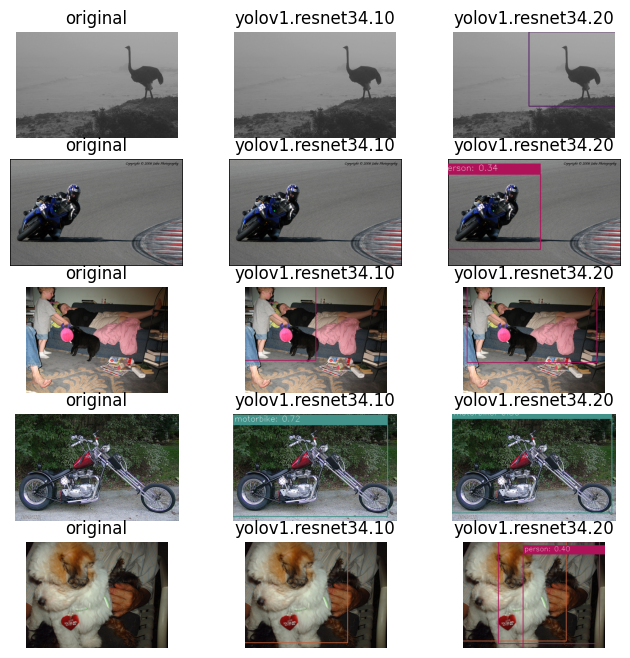

In [11]:
transform = predictor.prepare_inference()

image_paths = glob('D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/*')
random_selected_image_paths = random.choices(image_paths, k=5)

weight_paths = list(map(str, artifact_path.joinpath(predictor.cfg.MODEL.BACKBONE).glob('*.pth')))

titles = []
predictions = []
for image_path in random_selected_image_paths:
    img = load_image(image_path, is_numpy=True)
    predictions.append(img)
    titles.append('original')
    for weight_path in weight_paths:
        copied_img = img.copy()
        
        predictor.load_weight(weight_path)
        prediction = predictor.detect_single_image(img, transform)
        draw_pred(copied_img, prediction, predictor.class_names, class_color=predictor.palette)
        predictions.append(copied_img)
        titles.append(Path(weight_path).stem)

plot_grids(predictions, titles, 5, 1+len(weight_paths))

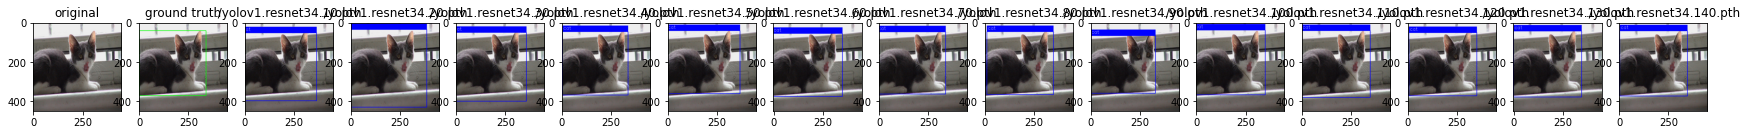

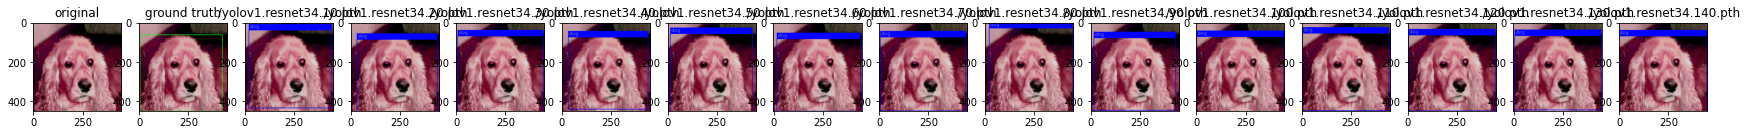

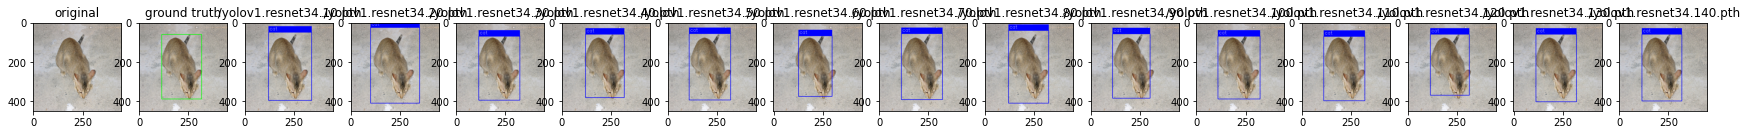

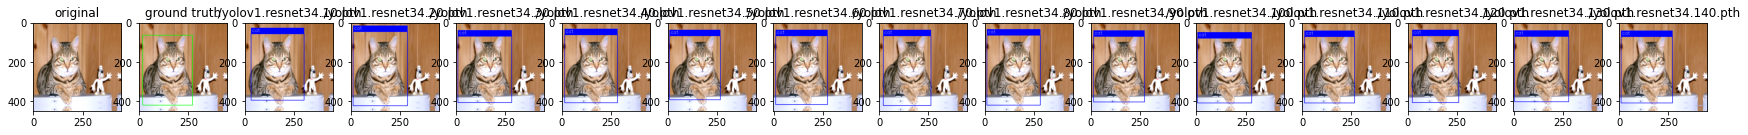

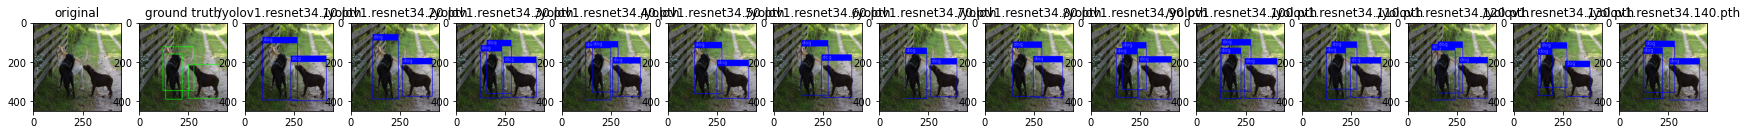

In [34]:
lots_of_prediction_and_lots_of_model(np.random.randint(low=0,high=len(trainset),size=5),
                                     )

# all epoch evaluation

In [ ]:
result_table = pd.concat([pd.read_csv(eval_file) for eval_file in artifact_path.glob('*eval.csv')], ignore_index=True)

In [25]:
result_table

Unnamed: 0  aeroplane   bicycle  \
0  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.285928  0.243080   
1  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.334452  0.264394   
2  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.343156  0.264758   

       bird      boat    bottle       bus       car       cat     chair  ...  \
0  0.151106  0.151515  0.090909  0.322694  0.268679  0.421576  0.090909  ...   
1  0.235090  0.160079  0.090909  0.432416  0.271636  0.519197  0.090909  ...   
2  0.237434  0.211670  0.090909  0.425696  0.271030  0.531502  0.090909  ...   

        dog     horse  motorbike    person  pottedplant     sheep      sofa  \
0  0.264929  0.304034   0.250271  0.141176     0.090909  0.090909  0.238564   
1  0.406530  0.402499   0.334981  0.166877     0.090909  0.163636  0.303895   
2  0.423003  0.411214   0.302629  0.171145     0.090909  0.174825  0.285663   

      train  tvmonitor       all  
0  0.327961   0.090909  0.214908  
1  0.414163   0.132353  0.264781  
2  0.403578   0.131752  0.273925  

[3 rows x 22 columns]

<AxesSubplot:>

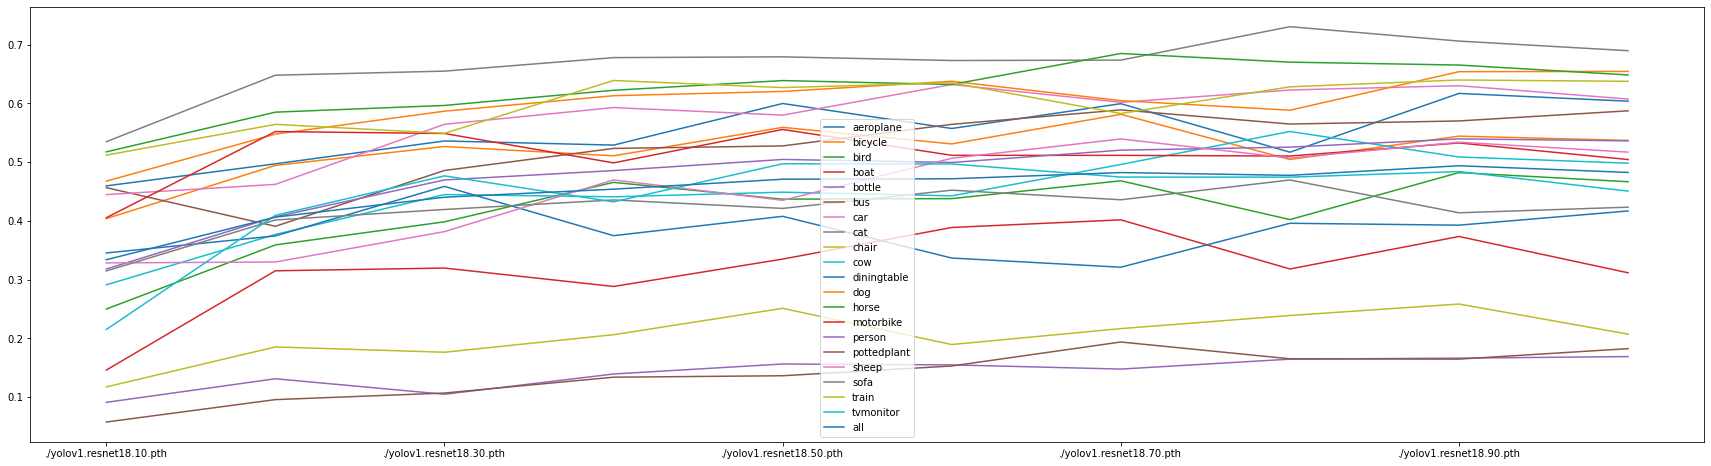

In [47]:
result_table.plot(figsize=(30,8))

<AxesSubplot:title={'center':'validation mAP on VOC 2007 test set'}>

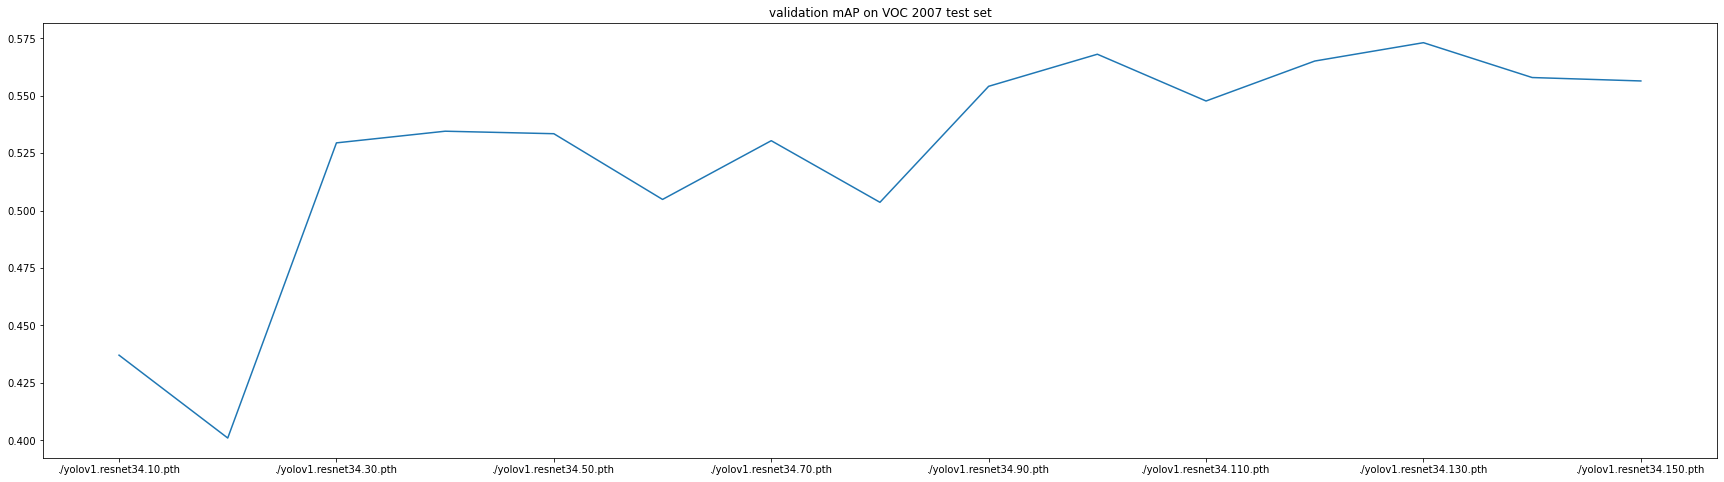

In [42]:
result_table['all'].plot(figsize=(30,8),title="validation mAP on VOC 2007 test set")

# debug

In [55]:
AP, _ = evaluator.evaluate_detector(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [01:17<00:00,  1.98it/s]


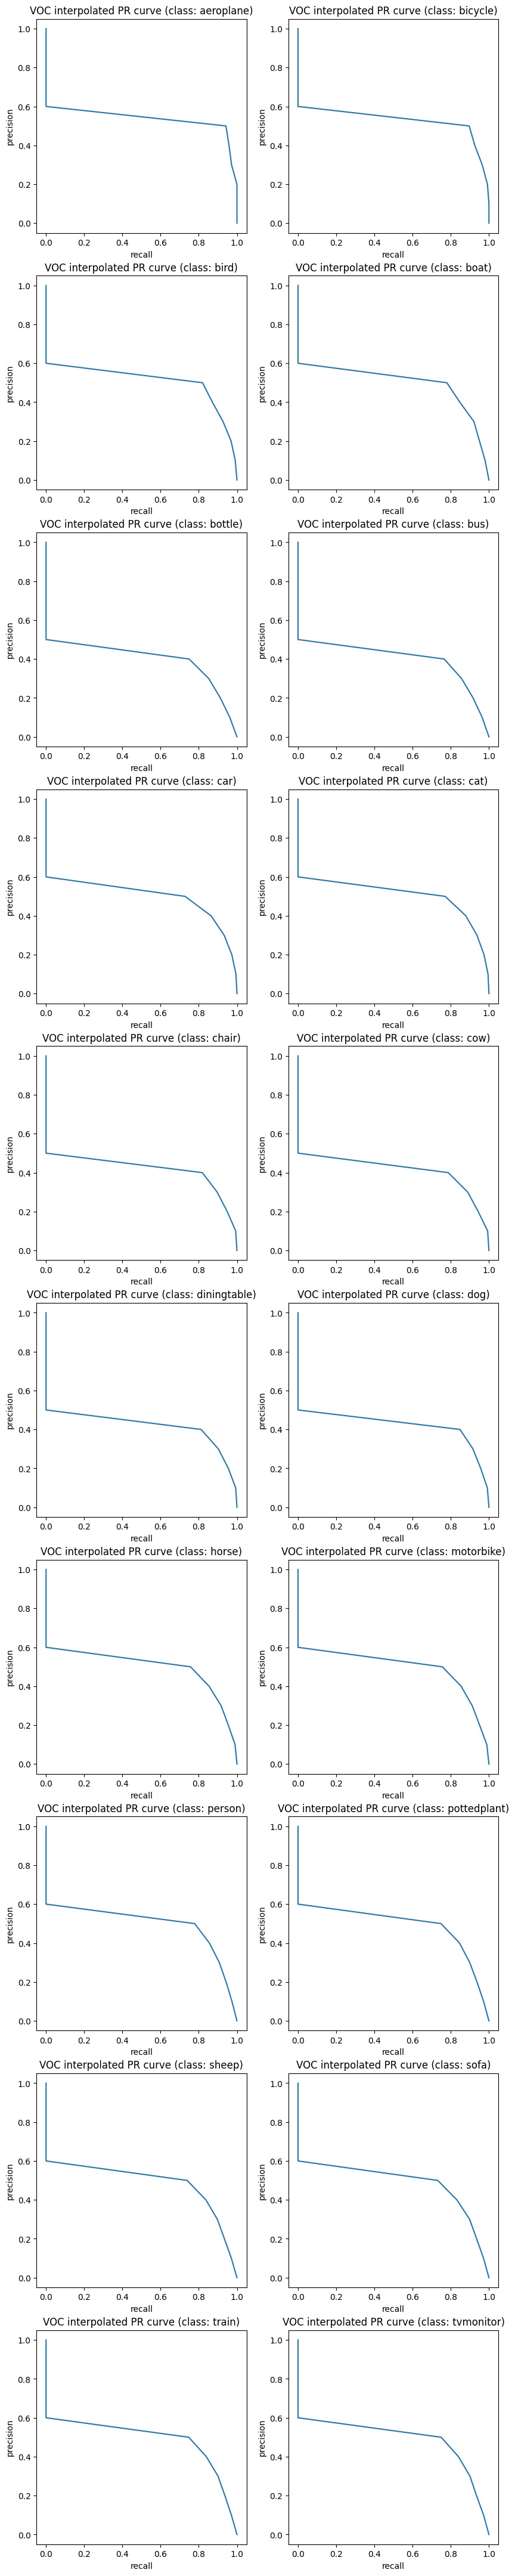

In [70]:
plt.figure(figsize=(10, 55))
for c_idx, class_name in enumerate(VOC_CLASS_NAMES):
    plt.subplot(len(VOC_CLASS_NAMES) // 2, 2, c_idx+1)
    plt.plot(AP[class_name][0], AP[class_name][1])
    plt.title(f"VOC interpolated PR curve (class: {class_name})")
    plt.xlabel("recall")
    plt.ylabel("precision")

In [43]:
interest_cls = 'aeroplane'
Iamnotsure = pd.DataFrame({
    'iou': torch.cat([a for a, b, c in debug_map[interest_cls] if a is not None],0).numpy(),
    'prob': torch.cat([b for a, b, c in debug_map[interest_cls] if b is not None],0).numpy(),
    'gt': sum(c for a, b, c in debug_map[interest_cls])
}).sort_values('prob',ascending=False)
Iamnotsure['TP'] = Iamnotsure['iou'].gt(0.5).cumsum()
Iamnotsure['precision'] = Iamnotsure['TP']/np.arange(1,len(Iamnotsure)+1)
Iamnotsure['recall'] = Iamnotsure['TP']/Iamnotsure['gt']
Iamnotsure

iou      prob     gt   TP  precision    recall
71   0.884566  0.890917  265.0    1   1.000000  0.003774
100  0.955297  0.890582  265.0    2   1.000000  0.007547
142  0.851079  0.879476  265.0    3   1.000000  0.011321
134  0.940841  0.871596  265.0    4   1.000000  0.015094
200  0.811990  0.857263  265.0    5   1.000000  0.018868
..        ...       ...    ...  ...        ...       ...
101  0.518033  0.335952  265.0  190   0.867580  0.716981
58   0.000000  0.321791  265.0  190   0.863636  0.716981
164  0.577316  0.320824  265.0  191   0.864253  0.720755
28   0.000000  0.319813  265.0  191   0.860360  0.720755
13   0.655200  0.318804  265.0  192   0.860987  0.724528

[223 rows x 6 columns]

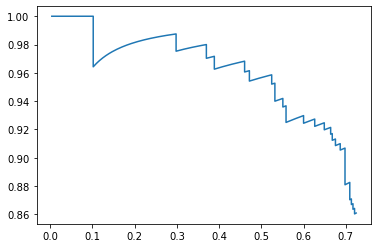

In [44]:
# plt.ylim(0,1.3)
plt.plot(Iamnotsure['recall'], Iamnotsure['precision'])

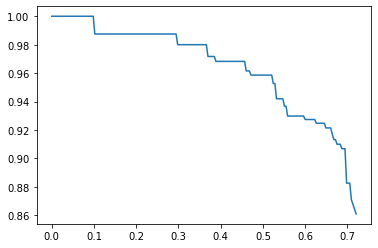

In [45]:
a,b = all_pr_curve(eval_table[interest_cls]['precision'],eval_table[interest_cls]['recall'])
plt.plot(b, a)

In [11]:
r18 = pd.read_csv('Final.1e-4/eval.csv',index_col=0)
r34 = pd.read_csv('Final.1e-4.34/eval.csv',index_col=0)

In [14]:
pd.concat([r18,r34]).loc[['./yolov1.resnet18.150.pth','./yolov1.resnet34.130.pth']].transpose()

./yolov1.resnet18.150.pth  ./yolov1.resnet34.130.pth
aeroplane                     0.659695                   0.699073
bicycle                       0.601857                   0.635265
bird                          0.528688                   0.610817
boat                          0.457822                   0.517191
bottle                        0.199932                   0.248924
bus                           0.630690                   0.716136
car                           0.658628                   0.670062
cat                           0.751293                   0.761671
chair                         0.216588                   0.309187
cow                           0.550103                   0.604650
diningtable                   0.491263                   0.451624
dog                           0.642533                   0.665584
horse                         0.673473                   0.693687
motorbike                     0.577631                   0.619246
person                        0.557463                   0.591511
pottedplant                   0.188593                   0.247500
sheep                         0.479674                   0.601104
sofa                          0.458513                   0.494099
train                         0.693138                   0.739554
tvmonitor                     0.460606                   0.585502
all                           0.523909                   0.573119

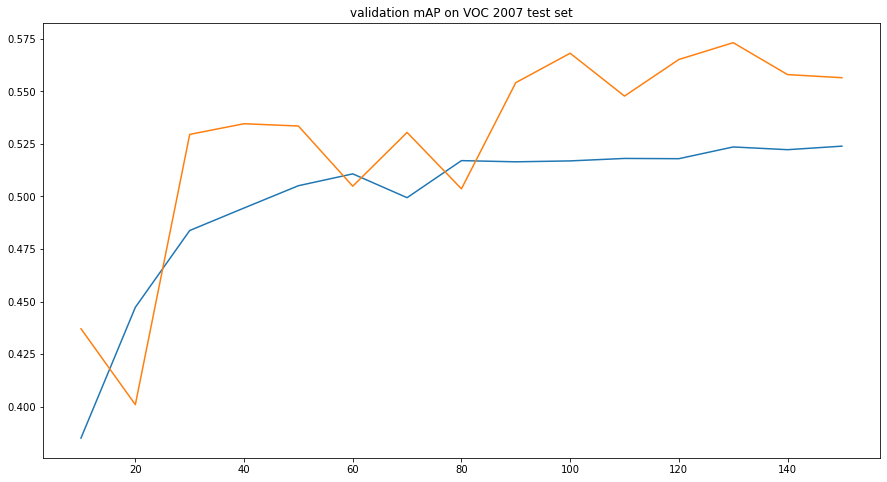

In [23]:
plt.figure(figsize=(15,8))
plt.title("validation mAP on VOC 2007 test set")
plt.plot(range(10,160,10), r18['all'])
plt.plot(range(10,160,10), r34['all'])